In [ ]:
ls /hybedata/Images/Robert/marie_celldeath/ibidi8_perTrial_v2_wt1_2019Jul01/

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from skimage import io
import pickle
from skimage.feature import corner_peaks, peak_local_max
from scipy.ndimage import gaussian_filter
import numpy as np
import pandas as pd

from metadata import *
from stkshow import *


from collections import Counter
from functools import partial

from skimage.measure import label, regionprops
from skimage.segmentation import watershed
from skimage.color import label2rgb
import itertools as it

from scipy.interpolate import splrep, sproot, splev


import seaborn as sns
import multiprocessing as mp
import itertools as it
from functools import partial


from scipy.ndimage import gaussian_filter
from skimage.transform import resize
from skimage.segmentation import watershed
from skimage.measure import label, regionprops
from skimage.color import label2rgb

from collections import Counter
import pickle
from skimage.transform import rescale
from skimage.filters import threshold_otsu, gaussian

from hybescope_config.microscope_config import *

from skimage.feature import corner_peaks
from skimage.segmentation import watershed
from skimage.measure import label
from skimage.filters import gaussian
from skimage.transform import rescale
from skimage.filters import threshold_otsu, gaussian
import seaborn as sns

from skimage.filters import threshold_otsu
from skimage.measure import regionprops
from collections import Counter
import os

ff = flatfield_dict['DeepBlue']


In [287]:
def diffGauss(stk, blur = (0.5,0.5,0.)):
    stk = stk.astype('float64')
    stk = stk.copy()
    lp = gaussian_filter(stk, (2.2, 2.2, 0))
    stk = stk-lp
    stk = gaussian_filter(stk, blur)
    np.place(stk, stk<0, 0)
    return stk.astype('int16')

def plot_spots_vs_thresh(spot_df, min_t=20, max_t=400, nt=500):
    ts = np.linspace(min_t, max_t, nt)
    ns = []
    for t in ts:
        ns.append(sum(spot_df.val>t))
    return ts, ns

def spot_properties(peaks, stk, fstk):
    props = []
    for coords in peaks:
        if coords[0]<3 or coords[0]>2048-3:
            props.append([np.nan]*3)
            continue
        elif coords[1]<3 or coords[1]>2048-3:
            props.append([np.nan]*3)
            continue
        vert_line = fstk[coords[0]-3:coords[0]+4, coords[1], coords[2]]
        hort_line = fstk[coords[0], coords[1]-3:coords[1]+4, coords[2]]
        h_fwhm = fwhm(hort_line)
        v_fwhm = fwhm(vert_line)
        props.append((fstk[coords[0], coords[1], coords[2]], h_fwhm, v_fwhm, 
                     coords[0], coords[1], coords[2]))
    return props



from skimage.morphology import selem
from skimage.morphology import dilation
def pfunc_zstk_filt(pname, threshold, md_local, acq=['tnfaip3'],
                    chan='FarRed', blur=(0.25,0.25,0.25), 
                   rel_thresh=0.2, npixels_thresh=6):
    print(pname, '\n')
    disk = selem.disk(2)
    stk = md_local.stkread(Position=pname, Channel=chan, hybe=acq)
    # Failed to load files
    if isinstance(stk, dict):
        return None
    fstk = diffGauss(stk, blur)
    peaks_coords = peak_local_max(fstk, threshold_abs=threshold,
                                  min_distance=3)
    peaks = peak_local_max(fstk, threshold_abs=threshold,
                           min_distance=3, indices=False)
    dfs = []
    for z in set(peaks_coords[:, 2]):
        img = fstk[:,:,z]
        labels = label(peaks[:, :, z])
        spot_labels = watershed(gaussian_filter(img, 1.2)*-1, labels, mask=dilation(peaks[:,:, z], selem=disk))
        spots = regionprops(spot_labels, img)
        npixels = np.array([p.area for p in spots])
        spot_means = np.array([p.mean_intensity for p in spots])
        spot_max = [p.max_intensity for p in spots]
        centroids = np.array([p.weighted_centroid for p in spots])
    #     rna = np.where((spot_means>threshold)&(npixels>=npixels_thresh))[0]
        rna = np.arange(len(spots))
        rna_coords = centroids[rna]
        spot_values = []
        for p in spots:
            vals = [img[y, x] for y, x in p.coords]
            spot_values.append(vals)
        df = pd.DataFrame(np.stack([spot_means[rna], rna_coords[:,0],
                                    rna_coords[:, 1],
                                    tuple(it.repeat(z, len(spot_means[rna])))], axis=1),
                          columns = ['val', 'y', 'x', 'z'])
        df['pixel_values'] = spot_values
        dfs.append(df)
    
    return pname, fstk.max(axis=2), pd.concat(dfs, ignore_index=True), spot_labels#fstk.max(axis=2), peaks, peaks_coords#, df


# def segment_gapdh(p, md, d, t, hybe='gapdh_tnfaip3_16'):
#     d = d[(d.h_fwhm>1.9) & (d.v_fwhm>1.9) & (d.val>gapdh_thresh)]
#     n = md.stkread(Channel='DeepBlue', Position=p, acq=hybe).mean(axis=2)
#     fn = gaussian_filter(n, 25)
#     fn = fn/ff
#     t = threshold_otsu(fn)
#     peaks = corner_peaks(fn, threshold_abs=t, min_distance=35,
#                          exclude_border=False, indices=False)
#     pcoords = corner_peaks(fn, threshold_abs=t, min_distance=35,
#                          exclude_border=False, indices=True)
#     nlabels=watershed(fn*-1, label(peaks), watershed_line=True, mask=fn>t)
#     himg, _, _ = np.histogram2d(d.y, d.x, bins=512, weights=np.log2(d.z))
#     himg = rescale(gaussian(himg, 3), preserve_range=True, mode='edge', order=3, scale=4)
#     rna_density = gaussian(himg, 10, preserve_range=True)
#     seg = watershed(rna_density*-1, nlabels, watershed_line=True, mask=rna_density>0.01)
#     return seg, nlabels, rna_density
# a,b,c=zip(*gapdh_results)
# with mp.Pool(16) as ppool:
#     cell_labels = ppool.starmap(segment_gapdh, zip(a, [md]*len(a), c, [130]*len(a)))
# cell_labels_seg = np.stack([i[0] for i in cell_labels])
# nuc_labels_seg = np.stack([i[1] for i in cell_labels])

def segment(p, md, nuc_thresh=5000, cyto_thresh=3200, 
           cyto_chan = 'Green', acq_name=''):
    try:
        cyto = md.stkread(Channel=cyto_chan, Position=p,
                          acq=acq_name).max(axis=2)
        cyto = gaussian(cyto, 5, preserve_range=True)
        cyto = cyto/flatfield_dict[cyto_chan]
        n = md.stkread(Channel='DeepBlue', Position=p,
                       acq=acq_name).mean(axis=2)
        fn = gaussian_filter(n, 25)
        fn = fn/ff
        peaks = corner_peaks(fn, threshold_abs=nuc_thresh, min_distance=35,
                             exclude_border=False, indices=False)
        pcoords = corner_peaks(fn, threshold_abs=nuc_thresh, min_distance=35,
                             exclude_border=False, indices=True)
        nlabels=watershed(fn*-1, label(peaks), watershed_line=True,
                          mask=fn>nuc_thresh)
        seg = watershed(cyto*-1, nlabels, watershed_line=True,
                        mask=cyto>cyto_thresh)
        return seg, cyto, nlabels, fn
    except Exception as e:
        print(p, e)
        return None


def add_cell_labels(posname, spot_df, label_img, nuc_label,
                    lbl_name, fwhm=1.9, spot_thresh=375, npixels_thresh=4):
#     spot_df = spot_df[(spot_df.h_fwhm>fwhm) & (spot_df.v_fwhm>fwhm)
#                       & (spot_df.val>thresh)].copy()
    npixels = np.array([sum(np.array(i)>spot_thresh) for i in spot_df.pixel_values])
    spot_df = spot_df[(npixels>npixels_thresh) & (spot_df.val>spot_thresh)]
    lbl = [label_img[yx[0], yx[1]] for yx in spot_df[['y', 'x']].values.astype(int)]
    nuc_lbl = [nuc_label[yx[0], yx[1]] for yx in spot_df[['y', 'x']].values.astype(int)]
    spot_df[lbl_name] = lbl
    spot_df['pos'] = posname
#     rprops = regionprops(label_img)
#     areas = {p.label:p.area for p in rprops}
    spot_df[lbl_name+'_nuc']=nuc_lbl
    spot_df = spot_df[spot_df[lbl_name]>0].copy()
#     areas = [areas[i] for i in spot_df.lbl]
#     spot_df['area'] = areas
    return posname, spot_df



In [63]:
#from scipy.ndimage import morphology




In [76]:
p.coords


NameError: name 'p' is not defined

In [69]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


/home/rfor10/.conda/envs/tfgpu/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [75]:
df

,val,y,x,z,npixels
0,862.538462,433.766521,590.219567,3.0,13.0
1,811.923077,513.093415,791.243581,3.0,13.0
2,408.461538,740.003390,1403.895857,3.0,13.0
3,654.769231,822.113487,782.862547,3.0,13.0
4,415.769231,1205.820537,1784.830712,3.0,13.0
5,448.076923,1337.086695,1187.149013,3.0,13.0
6,414.538462,1339.862312,1283.176285,3.0,13.0
7,510.769231,1593.362801,1173.983133,3.0,13.0
8,455.076923,1719.065585,928.141312,3.0,13.0
9,433.769231,1820.906366,910.252527,3.0,13.0


In [45]:
pname = md.posnames[55]
threshold=400
md_local = md

acq=['all'];
chan='FarRed'; blur=(0.25,0.25,0.25);
rel_thresh=0.2;
npixels_thresh=6

stk = md_local.stkread(Position=pname, Channel=chan, hybe=acq)
# Failed to load files
# if isinstance(stk, dict):
#     return None
fstk = diffGauss(stk, blur)
peaks_coords = peak_local_max(fstk, threshold_abs=threshold,
                              min_distance=3)
peaks = peak_local_max(fstk, threshold_abs=threshold,
                       min_distance=3, indices=False)


opening img_T4_site6_2_1_000000033_000000000_FarRed_000_033.tif

In [94]:
df = pd.concat(dfs, ignore_index=True)

In [74]:
plt.imshow(label2rgb(spot_labels, img*50))

/home/rfor10/.conda/envs/tfgpu/lib/python3.6/site-packages/skimage/color/colorlabel.py:162: UserWarning: Negative intensities in `image` are not supported
  warn("Negative intensities in `image` are not supported")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [4]:
md = Metadata('/mnt/HypeScope/Robert/marie_celldeath/ibidi8_perTrial_v2_wt1_2019Jul01//')
print(md.acqnames)

['all_1' 'all_4']


In [5]:
i = 11
nsites = 24
posnames = md.posnames[[i, i+nsites, i+nsites*2, i+nsites*3, i+nsites*4]]#,
                       # i+nsites*5, i+nsites*6, i+nsites*7]]
posnames

array(['T3_site12_3_2', 'B3_site11_3_1', 'T4_site10_2_5', 'B4_site9_2_4',
       'T1_site8_2_3'], dtype=object)

In [107]:
md.posnames[5]

'T3_site6_2_1'

In [108]:
pfunc = partial(pfunc_zstk_filt, md_local = md, acq='all',
                npixels_thresh=6, chan='FarRed',
               blur=(0.25, 0.25, 0.))

pname, fstk_max, df2, spot_labels = pfunc(md.posnames[5], 400)

T3_site6_2_1 

opening img_T3_site6_2_1_000000033_000000000_FarRed_000_033.tif

In [113]:
df[df.val>600].shape

(18, 5)

<IPython.core.display.Javascript object>


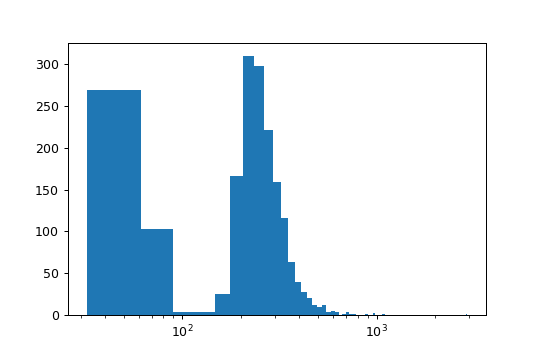

In [111]:
plt.hist(df.val, bins=100)
plt.xscale('log')

In [ ]:
class SpotCallZStack(object):
    def __init__(self, imgs = None, metadata = None):
        self.imgs = imgs
        self.metadata = metadata
        if (imgs is None) and (metadata is None):
            raise Exception("must supply either imgs or metadata of imgs")
        elif (imgs is None) and not (metadata is None):
            self.use = 'metadata'
        elif not (imgs is None) and (metadata is None):
            self.use = 'images'
        elif not (imgs is None) and not (metadata is None)
            self.use = 'both'
    def _get_images(self):
        if self.use == 'metadata':
            return self.metadata.stkread()
        elif self.use == 'images':
            return self.imgs
        elif self.use == 'both':
            return self.imgs
    def filter_images(self, blur_kernel = (0.5, 0.5, 0.), highpass_kernel=(2.2, 2.2, 0.)):
        stk = self._get_images()

In [41]:
import multiprocessing
from functools import partial

pfunc = partial(pfunc_zstk_filt, md_local = md, acq='all',
                npixels_thresh=6, chan='FarRed',
               blur=(0.25, 0.25, 0.))
# Range of thresholds to try
threshs = np.linspace(300, 1200, 12)

dfs_dict = {}
for pnamie in posnames:
    with multiprocessing.Pool(12) as ppool:
        
        results = ppool.starmap(pfunc, list(zip(it.repeat(pnamie,
                                                 len(threshs)), 
                                      threshs))
                               )
        _, _, dfs, _ = zip(*results)
        dfs_dict[pnamie] = dfs

T3_site12_3_2 

opening img_T3_site12_3_2_000000002_000000000_FarRed_000_002.tifT3_site12_3_2 

opening img_T3_site12_3_2_000000001_000000000_FarRed_000_001.tifT3_site12_3_2 

opening img_T3_site12_3_2_000000003_000000000_FarRed_000_003.tifT3_site12_3_2 

opening img_T3_site12_3_2_000000003_000000000_FarRed_000_003.tifT3_site12_3_2 

opening img_T3_site12_3_2_000000002_000000000_FarRed_000_002.tifT3_site12_3_2 

opening img_T3_site12_3_2_000000005_000000000_FarRed_000_005.tifT3_site12_3_2 

opening img_T3_site12_3_2_000000010_000000000_FarRed_000_010.tifT3_site12_3_2 

T3_site12_3_2 

opening img_T3_site12_3_2_000000011_000000000_FarRed_000_011.tifT3_site12_3_2 

opening img_T3_site12_3_2_000000006_000000000_FarRed_000_006.tifT3_site12_3_2 

opening img_T3_site12_3_2_000000012_000000000_FarRed_000_012.tifT3_site12_3_2 

opening img_T3_site12_3_2_000000033_000000000_FarRed_000_033.tifB3_site11_3_1 

opening img_B3_site11_3_1_000000002_000000000_FarRed_000_002.tifB3_site11_3_1 

opening 

In [33]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/rfor10/.conda/envs/tfgpu/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [38]:
k

'T1_site8_2_3'

In [42]:
for k, v in dfs_dict.items():
    print(k)
    i = 0
    for d in v:
        
        print(threshs[i], d.shape[0])
        i+=1

T3_site12_3_2
300.0 1606
381.8181818181818 778
463.6363636363636 413
545.4545454545455 227
627.2727272727273 129
709.090909090909 78
790.9090909090909 45
872.7272727272727 29
954.5454545454545 19
1036.3636363636363 9
1118.181818181818 6
1200.0 3
B3_site11_3_1
300.0 499
381.8181818181818 198
463.6363636363636 101
545.4545454545455 55
627.2727272727273 25
709.090909090909 16
790.9090909090909 13
872.7272727272727 3
954.5454545454545 2
1036.3636363636363 1
1118.181818181818 0
1200.0 0
T4_site10_2_5
300.0 774
381.8181818181818 325
463.6363636363636 152
545.4545454545455 96
627.2727272727273 52
709.090909090909 38
790.9090909090909 20
872.7272727272727 15
954.5454545454545 10
1036.3636363636363 6
1118.181818181818 3
1200.0 0
B4_site9_2_4
300.0 491
381.8181818181818 189
463.6363636363636 86
545.4545454545455 50
627.2727272727273 28
709.090909090909 22
790.9090909090909 12
872.7272727272727 9
954.5454545454545 6
1036.3636363636363 5
1118.181818181818 2
1200.0 0
T1_site8_2_3
300.0 573
381.8181

<IPython.core.display.Javascript object>


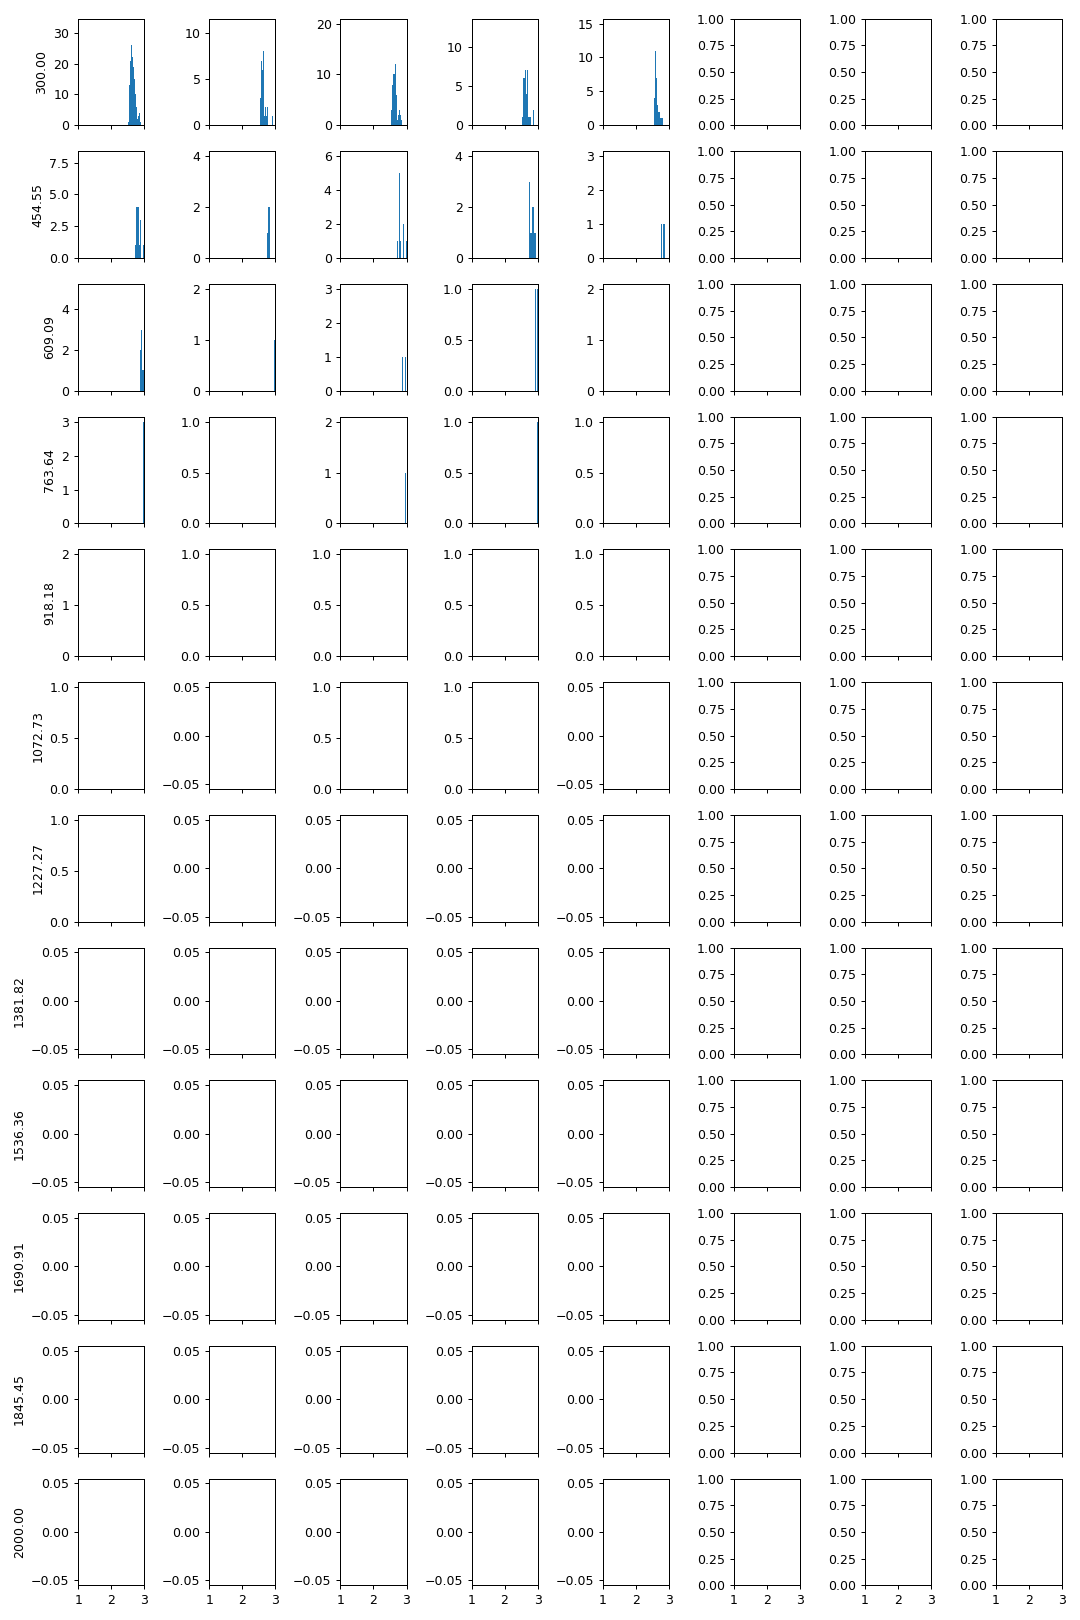

In [40]:
fig, axes = plt.subplots(len(threshs), 8, figsize=(12, 18), sharex=True, 
                        sharey=False)
col = 0
for pname, dfs in dfs_dict.items():
    row = 0
    
    for t, d in zip(threshs, dfs):
        axes[row, col].hist(np.log10(d.val), bins=200)
#         axes[row, col].vlines(np.log10(2600), 0, 100, linestyle='--', alpha=0.8)
        axes[row, col].set_xlim([1, 3])
        axes[row, 0].set_ylabel('{0:.2f}'.format(threshs[row]))
#         axes[col, row].set_xscale('log')
        row+=1
    col+=1
fig.tight_layout()

In [9]:
import multiprocessing
from functools import partial

pfunc = partial(pfunc_zstk_filt, md_local = md, acq='all',
                npixels_thresh=6, chan='Orange',
               blur=(0.25, 0.25, 0.))
# Range of thresholds to try
threshs = np.linspace(1000, 4500, 12)

dfs_dict = {}
for pnamie in posnames:
    with multiprocessing.Pool(12) as ppool:
        
        results = ppool.starmap(pfunc, list(zip(it.repeat(pnamie,
                                                 len(threshs)), 
                                      threshs))
                               )
        _, _, dfs, _ = zip(*results)
        dfs_dict[pnamie] = dfs

T1_site12_3_2 

opening img_T1_site12_3_2_000000006_000000000_Orange_000_006.tifT1_site12_3_2 

opening img_T1_site12_3_2_000000009_000000000_Orange_000_009.tifT1_site12_3_2 

opening img_T1_site12_3_2_000000017_000000000_Orange_000_017.tifT1_site12_3_2 

opening img_T1_site12_3_2_000000021_000000000_Orange_000_021.tifT1_site12_3_2 

opening img_T1_site12_3_2_000000021_000000000_Orange_000_021.tifT1_site12_3_2 

opening img_T1_site12_3_2_000000014_000000000_Orange_000_014.tifT1_site12_3_2 

opening img_T1_site12_3_2_000000021_000000000_Orange_000_021.tifT1_site12_3_2 

opening img_T1_site12_3_2_000000021_000000000_Orange_000_021.tifT1_site12_3_2 

opening img_T1_site12_3_2_000000010_000000000_Orange_000_010.tifT1_site12_3_2 

opening img_T1_site12_3_2_000000021_000000000_Orange_000_021.tifT1_site12_3_2 

opening img_T1_site12_3_2_000000015_000000000_Orange_000_015.tifT1_site12_3_2 

opening img_T1_site12_3_2_000000021_000000000_Orange_000_021.tifB1_site11_3_1 

opening img_B1_site11_3_

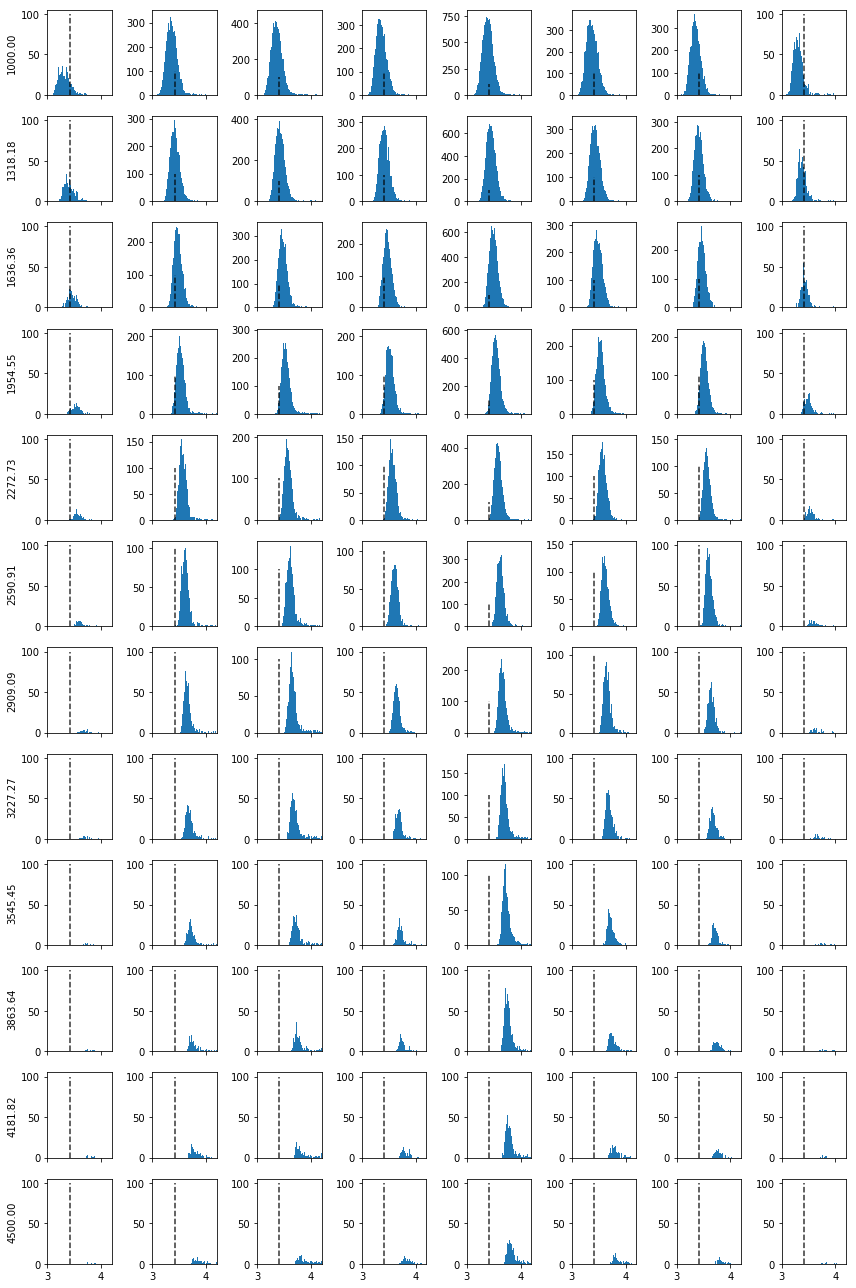

In [10]:
fig, axes = plt.subplots(len(threshs), 8, figsize=(12, 18), sharex=True, 
                        sharey=False)
col = 0
for pname, dfs in dfs_dict.items():
    row = 0
    
    for t, d in zip(threshs, dfs):
        axes[row, col].hist(np.log10(d.val), bins=200)
        axes[row, col].vlines(np.log10(2600), 0, 100, linestyle='--', alpha=0.8)
        axes[row, col].set_xlim([3, 4.2])
        axes[row, 0].set_ylabel('{0:.2f}'.format(threshs[row]))
#         axes[col, row].set_xscale('log')
        row+=1
    col+=1
fig.tight_layout()

In [117]:
nfkbia = 400
tnfaip3 = 400

In [118]:
pfunc = partial(pfunc_zstk_filt, acq=['all'],
                chan='FarRed', md_local=md, threshold=tnfaip3,
                npixels_thresh=6)
with mp.Pool(32) as ppool:
    tnfaip3_results = ppool.map(pfunc, md.posnames)
tnfaip3_results = [i for i in tnfaip3_results if not i is None]

T3_site1_1_1 

opening img_T3_site1_1_1_000000005_000000000_FarRed_000_005.tifT3_site3_1_3 

opening img_T3_site1_1_1_000000008_000000000_FarRed_000_008.tifT3_site5_1_5 

opening img_T3_site1_1_1_000000010_000000000_FarRed_000_010.tifT3_site7_2_2 

opening img_T3_site5_1_5_000000003_000000000_FarRed_000_003.tifT3_site9_2_4 

opening img_T3_site9_2_4_000000001_000000000_FarRed_000_001.tifT3_site11_3_1 

opening img_T3_site3_1_3_000000009_000000000_FarRed_000_009.tifT3_site13_3_3 

opening img_T3_site9_2_4_000000003_000000000_FarRed_000_003.tiffT3_site15_3_5 

opening img_T3_site9_2_4_000000004_000000000_FarRed_000_004.tiffT3_site17_4_2 

opening img_T3_site13_3_3_000000002_000000000_FarRed_000_002.tifT3_site19_4_4 

opening img_T3_site9_2_4_000000005_000000000_FarRed_000_005.tiffT3_site21_5_1 

opening img_T3_site9_2_4_000000006_000000000_FarRed_000_006.tiffT3_site23_5_3 

T3_site25_5_5 

opening img_T3_site9_2_4_000000007_000000000_FarRed_000_007.tiffB3_site2_1_2 

B3_site4_1_4 

openi

opening img_T1_site8_2_3_000000027_000000000_FarRed_000_027.tiffT1_site6_2_1 

opening img_T1_site6_2_1_000000005_000000000_FarRed_000_005.tiffT1_site12_3_2 

opening img_T1_site12_3_2_000000025_000000000_FarRed_000_025.tifB1_site3_1_3 

opening img_T1_site12_3_2_000000028_000000000_FarRed_000_028.tifT1_site16_4_1 

opening img_T1_site12_3_2_000000029_000000000_FarRed_000_029.tifT1_site20_4_5 

opening img_T1_site16_4_1_000000003_000000000_FarRed_000_003.tifB1_site4_1_4 

opening img_B1_site3_1_3_000000009_000000000_FarRed_000_009.tiffB1_site6_2_1 

B1_site1_1_1 

opening img_B1_site3_1_3_000000010_000000000_FarRed_000_010.tiffT1_site14_3_4 

opening img_T1_site14_3_4_000000002_000000000_FarRed_000_002.tifT1_site22_5_2 

opening img_B1_site4_1_4_000000007_000000000_FarRed_000_007.tiffB1_site8_2_3 

opening img_B1_site8_2_3_000000001_000000000_FarRed_000_001.tiffB1_site10_2_5 

opening img_B1_site6_2_1_000000007_000000000_FarRed_000_007.tiffT1_site18_4_3 

opening img_B1_site8_2_3_00000

In [123]:
_, _, a20_dfs, _ = zip(*tnfaip3_results)
a20_dfs = pd.concat(a20_dfs, ignore_index=True)

In [266]:
t = 375
npixels = np.array([sum(np.array(i)>t) for i in a20_dfs.pixel_values])

In [267]:
a20_dfs[(npixels>4) & (a20_dfs.val>550)].shape[0]/200

57.69

<IPython.core.display.Javascript object>


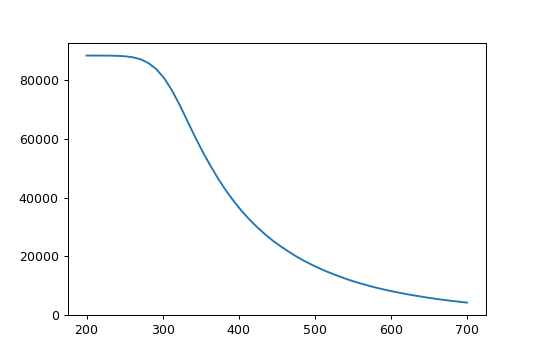

In [268]:
nspots = []
for t in np.linspace(200, 700):
    nspots.append((t, a20_dfs[(npixels>4) & (a20_dfs.val>t)].shape[0]))
    
x, y = zip(*nspots)
plt.plot(x, y)

In [165]:
a20_npixels = 4
a20_value = 425

'T1_site2_1_2'

In [239]:
md.posnames[138]

'B1_site14_3_4'

In [276]:
t = 375
t0 = tnfaip3_results[160][2]
t0_npixels = np.array([sum(np.array(i)>t) for i in t0.pixel_values])
t0[(t0_npixels>4) & (t0.val>375)].shape

(445, 5)

In [195]:
md.posnames[155]

'T2_site6_2_1'

<IPython.core.display.Javascript object>


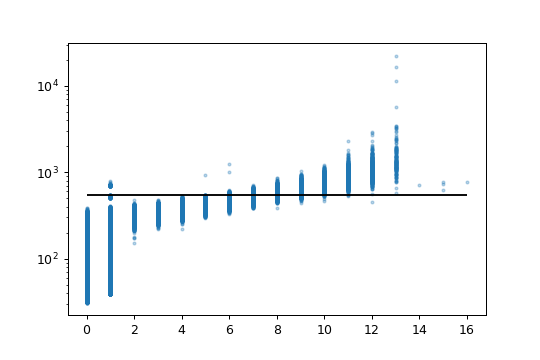

In [155]:
plt.scatter(npixels, a20_dfs.val, s=5, alpha=0.3)
plt.hlines(550, 0, 16)
plt.yscale('log')

<IPython.core.display.Javascript object>


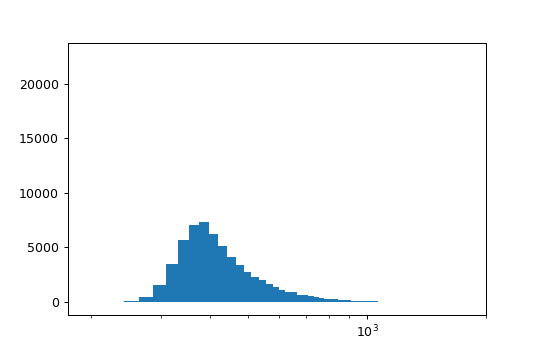

/home/rfor10/.conda/envs/tfgpu/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)


(174.373873286858, 2000)

In [150]:
plt.hist(a20_dfs[npixels>2].val, bins=1000)
plt.xscale('log')
plt.xlim([0, 2000])

<IPython.core.display.Javascript object>


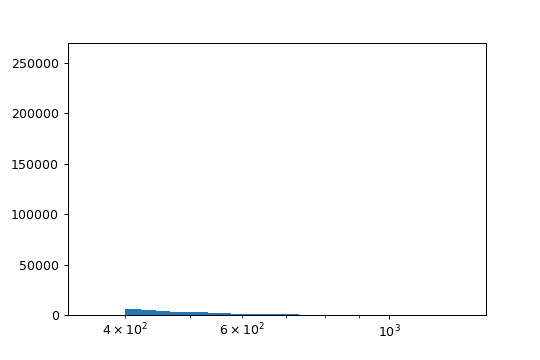

/home/rfor10/.conda/envs/tfgpu/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)


(327.07633618874934, 1400)

In [140]:
plt.hist(a20_dfs[a20_dfs.val>400].val, bins=1000)


<IPython.core.display.Javascript object>


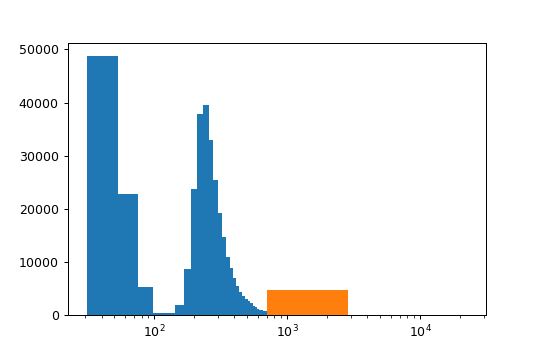

In [129]:
plt.hist(a20_dfs.val, bins=1000)
plt.xscale('log')

In [277]:
pfunc = partial(pfunc_zstk_filt, acq=['all'],
                chan='Orange', md_local=md, threshold=400,
                npixels_thresh=6)
with mp.Pool(32) as ppool:
    nfkbia_results = ppool.map(pfunc, md.posnames)
nfkbia_results = [i for i in nfkbia_results if not i is None]

T3_site1_1_1 

opening img_T3_site1_1_1_000000002_000000000_Orange_000_002.tifT3_site3_1_3 

opening img_T3_site3_1_3_000000002_000000000_Orange_000_002.tifT3_site5_1_5 

opening img_T3_site5_1_5_000000002_000000000_Orange_000_002.tifT3_site7_2_2 

opening img_T3_site3_1_3_000000005_000000000_Orange_000_005.tifT3_site9_2_4 

opening img_T3_site7_2_2_000000003_000000000_Orange_000_003.tifT3_site11_3_1 

opening img_T3_site9_2_4_000000002_000000000_Orange_000_002.tifT3_site13_3_3 

opening img_T3_site11_3_1_000000002_000000000_Orange_000_002.tifT3_site15_3_5 

opening img_T3_site11_3_1_000000003_000000000_Orange_000_003.tifT3_site17_4_2 

opening img_T3_site15_3_5_000000001_000000000_Orange_000_001.tifT3_site19_4_4 

opening img_T3_site17_4_2_000000002_000000000_Orange_000_002.tifT3_site21_5_1 

opening img_T3_site19_4_4_000000001_000000000_Orange_000_001.tifT3_site23_5_3 

opening img_T3_site17_4_2_000000003_000000000_Orange_000_003.tifT3_site25_5_5 

opening img_T3_site5_1_5_000000011_

opening img_T4_site24_5_4_000000028_000000000_Orange_000_028.tifB4_site7_2_2 

opening img_T1_site23_5_3_000000022_000000000_Orange_000_022.tifB4_site9_2_4 

opening img_B4_site9_2_4_000000033_000000000_Orange_000_033.tiffB4_site13_3_3 

opening img_B4_site13_3_3_000000013_000000000_Orange_000_013.tifB4_site17_4_2 

opening img_B4_site13_3_3_000000023_000000000_Orange_000_023.tifB4_site15_3_5 

opening img_B4_site15_3_5_000000012_000000000_Orange_000_012.tifB4_site11_3_1 

opening img_B4_site11_3_1_000000005_000000000_Orange_000_005.tifB4_site19_4_4 

opening img_B4_site19_4_4_000000016_000000000_Orange_000_016.tifB4_site21_5_1 

opening img_B4_site21_5_1_000000033_000000000_Orange_000_033.tifB1_site4_1_4 

opening img_B1_site4_1_4_000000014_000000000_Orange_000_014.tifB4_site23_5_3 

opening img_B1_site4_1_4_000000015_000000000_Orange_000_015.tifT1_site2_1_2 

opening img_T1_site2_1_2_000000008_000000000_Orange_000_008.tiffB1_site6_2_1 

opening img_B4_site23_5_3_000000023_000000000_O

In [14]:
pickle.dump({
    'nfkbia': nfkbia_results,
    'tnfaip3': tnfaip3_results
}, open(os.path.join(md.base_pth, 'resultsdump.pkl'), 'wb'))

# # # r = pickle.load(open('/scratch/marie_datadump.pkl', 'rb'))
# # # nfkbia_results = r['nfkbia']
# # # tnfaip3_results = r['tnfaip3']

In [56]:
md.acqnames

array(['all_2'], dtype=object)

In [20]:
print(threshold_otsu(cyto), threshold_otsu(fn))

5956.976624047475 3068.9502877141203


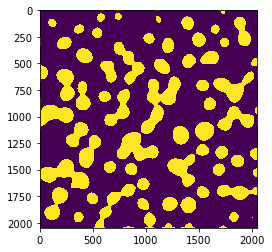

In [79]:
plt.imshow(fn>nthresh*0.75)

In [7]:
for p in posnames:
    seg, cyto, nlabels, fn = seg_pfunc(p)
    print('\n', p, threshold_otsu(cyto), threshold_otsu(fn))

opening img_T1_site12_3_2_000000021_000000000_DeepBlue_000_021.tif
 T1_site12_3_2 5454.6518294503085 3083.4580942879547
opening img_B1_site11_3_1_000000021_000000000_DeepBlue_000_021.tif
 B1_site11_3_1 26062.89565190248 2403.8117365998173
opening img_T2_site10_2_5_000000021_000000000_DeepBlue_000_021.tif
 T2_site10_2_5 5834.932012696037 3026.7165179258695
opening img_B2_site9_2_4_000000021_000000000_DeepBlue_000_021.tif
 B2_site9_2_4 5171.392720569123 2531.1605384803947
opening img_T3_site8_2_3_000000021_000000000_DeepBlue_000_021.tif
 T3_site8_2_3 5735.250926463001 2309.2760055179924
opening img_B3_site7_2_2_000000021_000000000_DeepBlue_000_021.tif
 B3_site7_2_2 5541.792309058093 2342.4553935828926
opening img_T4_site6_2_1_000000021_000000000_DeepBlue_000_021.tif
 T4_site6_2_1 4833.693374997129 3007.5835589289254
opening img_B4_site5_1_5_000000021_000000000_DeepBlue_000_021.tif
 B4_site5_1_5 24043.675911361966 3356.3309412370745


In [58]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [278]:
md.acqnames

array(['all_1', 'all_4'], dtype=object)

In [281]:
fn.mean()

166.56259009400063

opening img_B3_site1_1_1_000000033_000000000_DeepBlue_000_033.tif568.2857248490936 195.24486545856576


<IPython.core.display.Javascript object>


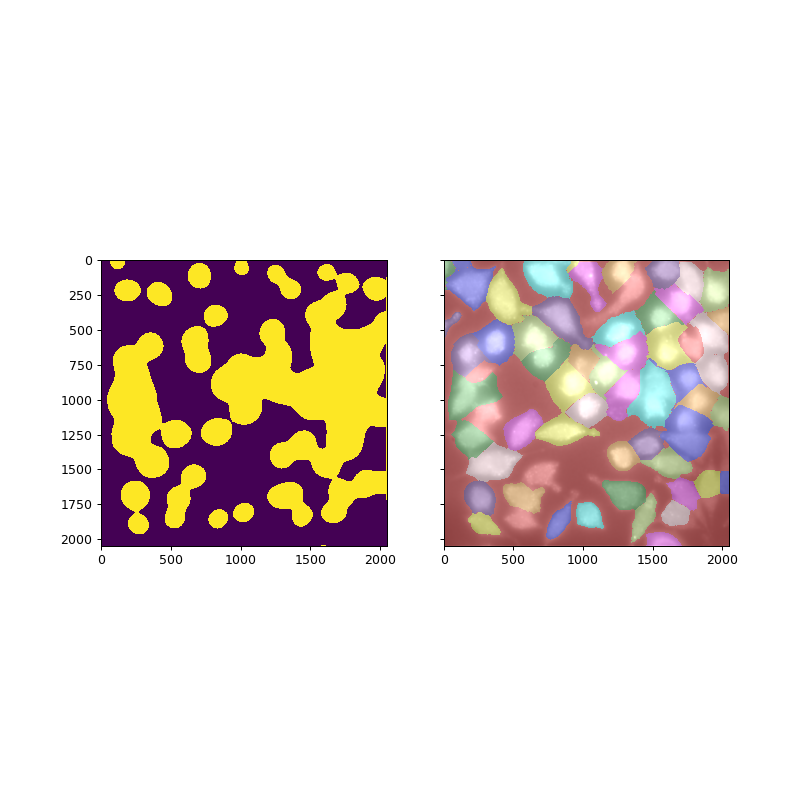

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [284]:
nthresh = 180
cthresh = 450
acqname =['all_1', 'all_4']
pnamie = md.posnames[25]
seg_pfunc = partial(segment, md=md, cyto_thresh=cthresh, nuc_thresh=nthresh, 
                   acq_name=acqname)

seg, cyto, nlabels, fn = seg_pfunc(pnamie)

print(threshold_otsu(cyto), threshold_otsu(fn))

fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(9,9))


ax[0].imshow(fn>nthresh)
ax[1].imshow(label2rgb(seg, cyto/np.percentile(cyto.flatten()[::10], 90)))

In [285]:
seg_pfunc = partial(segment, md=md, cyto_thresh=cthresh, nuc_thresh=nthresh, 
                   acq_name=acqname)
with mp.Pool(18) as ppool:
    cell_labels = ppool.map(seg_pfunc, md.posnames[:])
cell_labels_seg = [i[0] if not i is None else np.zeros((2048, 2048)) for i in cell_labels]
cyto_imgs = [i[1] if not i is None else np.zeros((2048, 2048)) for i in cell_labels]
nuc_labels_seg = [i[2] if not i is None else np.zeros((2048, 2048)) for i in cell_labels]
cell_labels_seg= np.array(cell_labels_seg).astype('uint8')
nuc_labels_seg = np.array(nuc_labels_seg).astype('uint8')

opening img_B2_site17_4_2_000000033_000000000_DeepBlue_000_033.tif

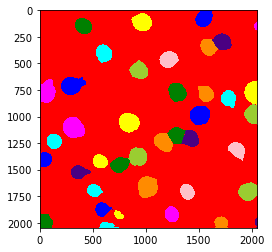

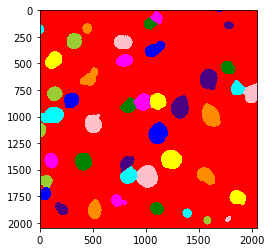

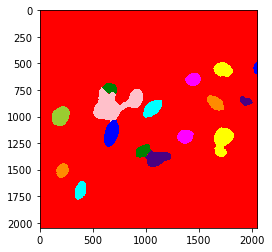

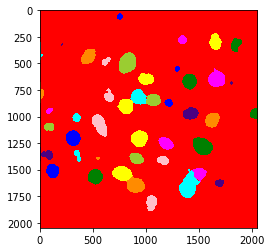

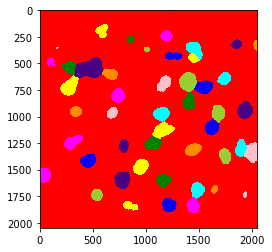

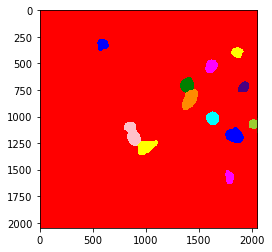

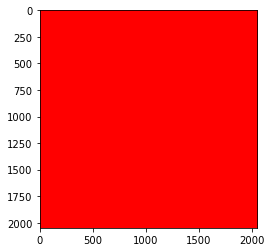

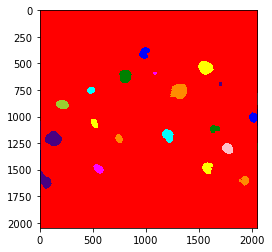

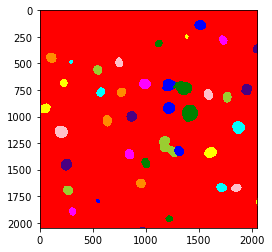

KeyboardInterrupt: 

In [71]:
for i in range(0, cell_labels_seg.shape[0], 15):
    plt.imshow(label2rgb(cell_labels_seg[i, :, :]))
    plt.show()

In [101]:
pnames, imgs, dfs, spot_labels = zip(*tnfaip3_results)
idx = np.where([True if i in pnames else False for i in md.posnames])[0]
with mp.Pool(32) as ppool:
    dfs = ppool.starmap(add_cell_labels, zip(pnames, dfs, [cell_labels_seg[i, :, :] for i in idx],
                                             [nuc_labels_seg[i, :, :] for i in idx],
                                             ['tnfaip3']*len(pnames), it.repeat(375, len(pnames))))
pnames, dfs = zip(*dfs)
a20_df = pd.concat(dfs, ignore_index=True)

In [58]:
pnames, imgs, dfs, spot_labels = zip(*nfkbia_results)
idx = np.where([True if i in pnames else False for i in md.posnames])[0]
with mp.Pool(32) as ppool:
    dfs = ppool.starmap(add_cell_labels, zip(pnames, dfs, [cell_labels_seg[i, :, :] for i in idx],
                                             [nuc_labels_seg[i, :, :] for i in idx],
                                             ['nfkbia']*len(pnames), it.repeat(375, len(pnames))))
pnames, dfs = zip(*dfs)
nfk_df = pd.concat(dfs, ignore_index=True)

In [102]:
areas = {}
for i, p in enumerate(md.posnames):
    l = cell_labels_seg[i, :, :]
    props = regionprops(l)
    for pr in props:
        a = pr.area
        ix = pr.label
        areas[(p, ix)] = a

In [104]:
nfk_gcounts = {}
nfk_nuc = {}
# for g, d in nfk_df.groupby('pos'):
#     counts = Counter(d.nfkbia)
#     ncounts = Counter(d.nfkbia_nuc)
#     for i, c in counts.items():
#         if i == 0:
#             continue
#         nfk_gcounts[(g, i)] = c
#     for i, c in ncounts.items():
#         if i == 0:
#             continue
#         nfk_nuc[(g, i)] = c

a20_gcounts = {}
a20_nuc = {}
for g, d in a20_df.groupby('pos'):
    counts = Counter(d.tnfaip3)
    ncounts = Counter(d.tnfaip3_nuc)
    for i, c in counts.items():
        if i == 0:
            continue
        a20_gcounts[(g, i)] = c
    for i, c in ncounts.items():
        if i == 0:
            continue
        a20_nuc[(g, i)] = c
        

In [114]:
pairs = []
for k, v in areas.items():
    if k in a20_gcounts:
        a = a20_gcounts[k]
        if k in a20_nuc:
            a_nuc = a20_nuc[k]
        else:
            a_nuc = 0
    else:
        a = 0
        a_nuc = 0
    if k in nfk_gcounts:
        n = nfk_gcounts[k]
        if k in nfk_nuc:
            n_nuc = nfk_nuc[k]
        else:
            n_nuc = 0
    else:
        n = 0
        n_nuc = 0
    if k not in areas:
        continue
    ar = areas[k]
    site = k[0].split('_')[0]
    k = site
    if k=='T1':
        t=0
    elif k=='T2':
        t=1
    elif k=='T3':
        t=0
    elif k=='T4':
        t=1.
    elif k=='B1':
        t=2.5
    elif k=='B2':
        t=4.5
    elif k=='B3':
        t=2.5
    elif k=='B4':
        t=4.5
#     elif k[0][0]=='6':
#         t=120
    pairs.append((t, k, ar/100, a, n, a_nuc, n_nuc))
cdf = pd.DataFrame(pairs, columns=['t', 'id', 'area', 'a20', 'nfkbia', 'a20_nuc', 
                                  'nfkbia_nuc'])
cdf['a20_vol'] = (cdf['a20']/cdf.area)*cdf.area.mean()
cdf['a20_log2p1_vol'] = np.log2(cdf['a20_vol']+1)
cdf['ikbia_log2p1'] = np.log2(cdf['nfkbia']+1)

In [115]:
cdf

,t,id,area,a20,nfkbia,a20_nuc,nfkbia_nuc,a20_vol,a20_log2p1_vol,ikbia_log2p1
0,0.0,T1,50.52,2,0,1,0,18.699950,4.300120,0.0
1,0.0,T1,84.75,3,0,0,0,16.720734,4.147366,0.0
2,0.0,T1,298.12,3,0,1,0,4.753395,2.524414,0.0
3,0.0,T1,342.20,7,0,1,0,9.662552,3.414481,0.0
4,0.0,T1,279.67,5,0,3,0,8.444966,3.239546,0.0
5,0.0,T1,397.28,11,0,5,0,13.078857,3.815458,0.0
6,0.0,T1,177.48,4,0,1,0,10.645949,3.541756,0.0
7,0.0,T1,207.97,1,0,0,0,2.271293,1.709861,0.0
8,0.0,T1,410.76,7,0,3,0,8.049774,3.177882,0.0
9,0.0,T1,436.21,14,0,7,0,15.160245,4.014377,0.0


In [124]:
wt = [True if s in ['T1', 'T2', 'B1', 'B2'] else False for s in cdf.id]
ko = [True if s in ['T3', 'T4', 'B3', 'B4'] else False for s in cdf.id]

In [123]:
wt.columns

Index(['t', 'id', 'area', 'a20', 'nfkbia', 'a20_nuc', 'nfkbia_nuc', 'a20_vol',
       'a20_log2p1_vol', 'ikbia_log2p1'],
      dtype='object')

In [125]:
wt = cdf[wt]
wt = wt[wt.area<2000]
ko = cdf[ko]
ko = ko[ko.area<2000]

Text(0.5, 1.0, 'Wildtype')

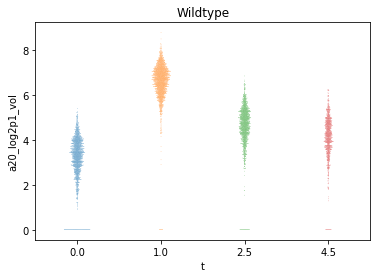

In [137]:
sns.swarmplot(x = 't', y='a20_log2p1_vol', data=wt, size=0.5)
plt.title('Wildtype')

In [77]:

pickle.dump(cdf, open('/hybedata/Images/Robert/marie_celldeath/ibidi8_perTrial2_2019Jun15/spotsdf.pkl'), 'wb')
# cdf = pickle.load(open(os.path.join(md.base_pth, 'spotsdf.pkl'), 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: '/hybedata/Images/Robert/marie_celldeath/ibidi8_perTrial2_2019Jun15/spotsdf.pkl'

In [106]:
# Threshold on too big and too small cells
cdf = cdf[(cdf.area<5000) & (cdf.area>100)]

(0.0, 50)

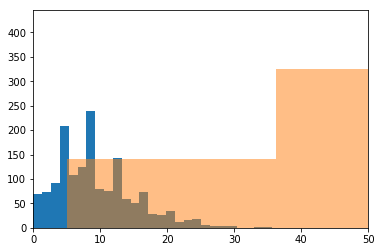

In [107]:
plt.hist(cdf[cdf.t==0].a20, bins=50)
plt.hist(cdf[cdf.t==0.5
            ].a20, bins=50, alpha=0.5)
plt.xlim([0., 50])

In [133]:
ts = []
a20s = []
means = []
stds_mu = []
t = []
# ptile90_basal = np.percentile(cdf[(cdf.area>150) & (cdf.t==0)]['a20_logp1'], 90)
percentGT_ptile90 = []
for g, d in ko.groupby('t'):
    ts += list(it.repeat(g, d.shape[0]))
    a20s += list(d.a20)
    means.append(np.mean(d.a20))
    stds_mu.append(np.std(d.a20)/np.sqrt(d.shape[0]))
#     percentGT_ptile90.append(d.)
    t.append(g)

In [110]:
len(ts), len(a20s), len(stds_mu)

(5577, 5577, 4)

Text(0, 0.5, 'Fold Change')

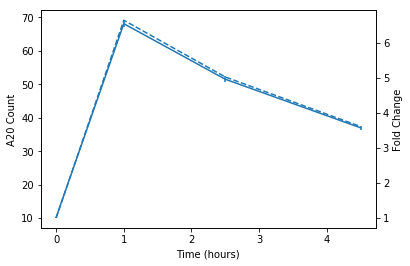

In [134]:
plt.errorbar(t, means, yerr=stds_mu)
plt.ylabel('A20 Count')
plt.xlabel('Time (hours)')
ax = plt.twinx()
ax.plot(t, np.array(means)/means[0], linestyle='--')
ax.set_ylabel('Fold Change')

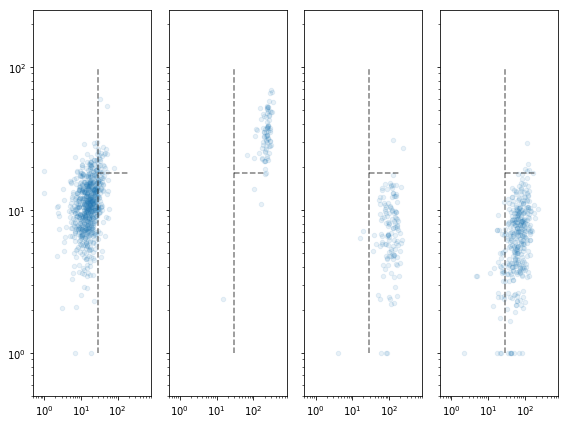

In [67]:
size_thresh = 150
subdf = cdf[(cdf.area>size_thresh)]# & (cdf.gapdh<2000) & (cdf.gapdh>150)]
pairs = subdf[['nfkbia', 'a20']]/(subdf.area/subdf.area.mean())[:, np.newaxis]
pairs = pairs+1
h0 = np.where(subdf[subdf.area>size_thresh].t==0)[0]
h30 = np.where(subdf[subdf.area>size_thresh].t==1)[0]
h60 = np.where(subdf[subdf.area>size_thresh].t==4.5)[0]
h90 = np.where(subdf[subdf.area>size_thresh].t==8)[0]
# h120 = np.where(subdf[subdf.area>size_thresh].t==120)[0]
pairs = pairs.values
fig, ax = plt.subplots(1,4, sharex=True, sharey=True, figsize=(8, 6))#,sharex=True,sharey=True)
s = 20
ax[0].scatter(pairs[h0, 0], pairs[h0, 1], s=s, alpha=0.1, marker='o')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].vlines(np.percentile(pairs[h0, 0], 90), 1, 100, linestyle='dashed', alpha=0.5)
ax[0].hlines(np.percentile(pairs[h0, 1], 90), np.percentile(pairs[h0, 0], 90), 200, linestyle='dashed', alpha=0.5)
ax[1].scatter(pairs[h30, 0], pairs[h30, 1], s=s, alpha=0.1, marker='o')
ax[1].vlines(np.percentile(pairs[h0, 0], 90), 1, 100, linestyle='dashed', alpha=0.5)
ax[1].hlines(np.percentile(pairs[h0, 1], 90), np.percentile(pairs[h0, 0], 90), 200, linestyle='dashed', alpha=0.5)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
# ax[1].set_xticks([])
# ax[1].set_yticks([])
ax[2].scatter(pairs[h60, 0], pairs[h60, 1], s=s, alpha=0.1, marker='o')
ax[2].vlines(np.percentile(pairs[h0, 0], 90), 1, 100, linestyle='dashed', alpha=0.5)
ax[2].hlines(np.percentile(pairs[h0, 1], 90), np.percentile(pairs[h0, 0], 90), 200, linestyle='dashed', alpha=0.5)
ax[2].set_xscale('log')
ax[2].set_yscale('log')
# ax[2].set_xticks([])
# ax[2].set_yticks([])
ax[3].scatter(pairs[h90, 0], pairs[h90, 1], s=s, alpha=0.1, marker='o')
ax[3].vlines(np.percentile(pairs[h0, 0], 90), 1, 100, linestyle='dashed', alpha=0.5)
ax[3].hlines(np.percentile(pairs[h0, 1], 90), np.percentile(pairs[h0, 0], 90), 200, linestyle='dashed', alpha=0.5)
ax[3].set_xscale('log')
ax[3].set_yscale('log')
# ax[3].set_xticks([])
# ax[3].set_yticks([])
# ax[4].scatter(pairs[h120, 0], pairs[h120, 1], s=s, alpha=0.1, marker='o')
# ax[4].vlines(np.percentile(pairs[h0, 0], 90), 1, 100, linestyle='dashed', alpha=0.5)
# ax[4].hlines(np.percentile(pairs[h0, 1], 90), np.percentile(pairs[h0, 0], 90), 200, linestyle='dashed', alpha=0.5)
# ax[4].set_xscale('log')
# ax[4].set_yscale('log')
# ax[4].set_xticks([])
# ax[4].set_yticks([])
# ax[0].set_xlabel('IKBA')
# ax[0].set_ylabel('A20')
ax[3].set_ylim([0.5, 250])
ax[3].set_xlim([0.5, 800])
plt.tight_layout()

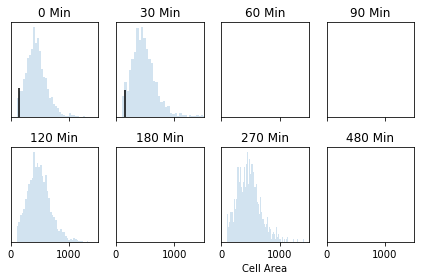

In [111]:
fig, ax = plt.subplots(2, 4, sharex=True, figsize=(6, 4))
nbin = 100
alph = 0.2
ax[0, 0].hist(cdf[cdf.t==0].area, bins=nbin, alpha=alph)
ax[0, 0].set_title('0 Min')
ax[0,0].vlines(150, 0, 50)
ax[0,0].set_yticks([])
ax[0, 1].hist(cdf[cdf.t==0.5].area, bins=nbin, alpha=alph)
ax[0, 1].set_title('30 Min')
ax[0, 1].set_yticks([])
ax[0,1].vlines(150, 0, 50)
ax[0, 2].hist(cdf[cdf.t==1].area, bins=nbin, alpha=alph)
ax[0, 2].set_title('60 Min')
ax[0,2].set_yticks([])
ax[0, 3].hist(cdf[cdf.t==1.5].area, bins=nbin, alpha=alph)
ax[0, 3].set_title('90 Min')
ax[0,3].set_yticks([])
ax[1, 0].hist(cdf[cdf.t==2].area, bins=nbin, alpha=alph)
ax[1, 0].set_title('120 Min')
ax[1, 0].set_yticks([])
ax[1, 1].hist(cdf[cdf.t==3].area, bins=nbin, alpha=alph)
ax[1, 1].set_title('180 Min')
ax[1, 1].set_yticks([])

ax[1, 2].hist(cdf[cdf.t==4.5].area, bins=nbin, alpha=alph)
ax[1, 2].set_title('270 Min')
ax[1, 2].set_yticks([])

ax[1, 3].hist(cdf[cdf.t==8].area, bins=nbin, alpha=alph)
ax[1, 3].set_title('480 Min')
ax[1, 3].set_yticks([])


fig.subplots_adjust(hspace=0.2, wspace=0.025)
ax[1, 2].set_xlim([0, 1500])
ax[1, 2].set_xlabel('Cell Area')
plt.tight_layout()

AttributeError: 'DataFrame' object has no attribute 'a20_logp1_vol'

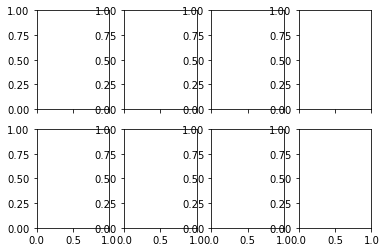

In [112]:
fig, ax = plt.subplots(2, 4, sharex=True, figsize=(6, 4))
nbin = 15
alph = 0.2
ax[0, 0].hist(cdf[cdf.t==0].a20_logp1_vol, bins=nbin, alpha=alph)
ax[0, 0].set_title('0 Min')
ax[0,0].set_yticks([])
ax[0, 1].hist(cdf[cdf.t==0.5].a20_logp1_vol, bins=nbin, alpha=alph)
ax[0, 1].set_title('30 Min')
ax[0, 1].set_yticks([])
ax[0, 2].hist(cdf[cdf.t==1].a20_logp1_vol, bins=nbin, alpha=alph)
ax[0, 2].set_title('60 Min')
ax[0,2].set_yticks([])
ax[0, 3].hist(cdf[cdf.t==1.5].a20_logp1_vol, bins=nbin, alpha=alph)
ax[0, 3].set_title('90 Min')
ax[0,3].set_yticks([])
ax[1, 0].hist(cdf[cdf.t==2].a20_logp1_vol, bins=nbin, alpha=alph)
ax[1, 0].set_title('120 Min')
ax[1, 0].set_yticks([])
ax[1, 1].hist(cdf[cdf.t==3].a20_logp1_vol, bins=nbin, alpha=alph)
ax[1, 1].set_title('180 Min')
ax[1, 1].set_yticks([])

ax[1, 2].hist(cdf[cdf.t==4.5].a20_logp1_vol, bins=nbin, alpha=alph)
ax[1, 2].set_title('270 Min')
ax[1, 2].set_yticks([])

ax[1, 3].hist(cdf[cdf.t==8].a20_logp1_vol, bins=nbin, alpha=alph)
ax[1, 3].set_title('480 Min')
ax[1, 3].set_yticks([])
fig.subplots_adjust(hspace=0.2, wspace=0.025)
# ax[1, 2].set_xlim([0, 3000])
ax[1, 2].set_xlabel('Log2 A20')
ax[0,0].set_xlim([4, 8])
plt.tight_layout()

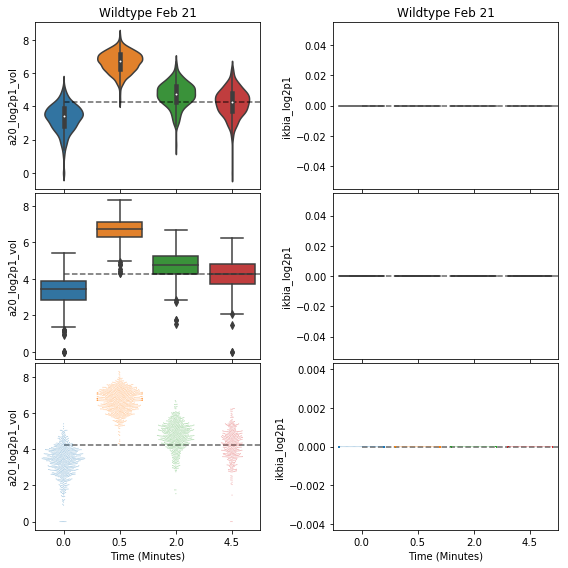

In [113]:


fig, ax = plt.subplots(3,2, sharex=True, figsize=(8, 8))
sns.violinplot(x='t', y='a20_log2p1_vol', data=cdf[cdf.area>150].iloc[::2], ax = ax[0, 0])
ax[0, 0].set_xlabel('')
ax[0, 0].set_xticks([])
sns.boxplot(x='t', y='a20_log2p1_vol', data=cdf[cdf.area>150].iloc[::2], ax = ax[1, 0])
ax[1, 0].set_xlabel('')
ax[1, 0].set_xticks([])
sns.swarmplot(x='t', y='a20_log2p1_vol', data=cdf[cdf.area>150].iloc[::2], ax = ax[2, 0],
              size=1, alpha=0.4)
ax[2, 0].set_xlabel('Time (Minutes)')
ax[0, 0].set_title('Wildtype Feb 21')


sns.violinplot(x='t', y='ikbia_log2p1', data=cdf[cdf.area>150].iloc[::2], ax = ax[0, 1])
ax[0, 1].set_xlabel('')
ax[0, 1].set_xticks([])
sns.boxplot(x='t', y='ikbia_log2p1', data=cdf[cdf.area>150].iloc[::2], ax = ax[1, 1])
ax[1, 1].set_xlabel('')
ax[1, 1].set_xticks([])
sns.swarmplot(x='t', y='ikbia_log2p1', data=cdf[cdf.area>150].iloc[::2], ax = ax[2, 1],
              size=1, alpha=0.4)
ax[2, 1].set_xlabel('Time (Minutes)')
ax[0, 1].set_title('Wildtype Feb 21')


ax[0, 0].hlines(np.percentile(cdf[(cdf.area>150) & (cdf.t==0)]['a20_log2p1_vol'], 90), 0, 480, 
               linestyle='--', alpha=0.6)
ax[1, 0].hlines(np.percentile(cdf[(cdf.area>150) & (cdf.t==0)]['a20_log2p1_vol'], 90), 0, 480, 
               linestyle='--', alpha=0.6)
ax[2, 0].hlines(np.percentile(cdf[(cdf.area>150) & (cdf.t==0)]['a20_log2p1_vol'], 90), 0, 480, 
               linestyle='--', alpha=0.6)

ax[0, 1].hlines(np.percentile(cdf[(cdf.area>150) & (cdf.t==0)]['ikbia_log2p1'], 90), 0, 480, 
               linestyle='--', alpha=0.6)
ax[1, 1].hlines(np.percentile(cdf[(cdf.area>150) & (cdf.t==0)]['ikbia_log2p1'], 90), 0, 480, 
               linestyle='--', alpha=0.6)
ax[2, 1].hlines(np.percentile(cdf[(cdf.area>150) & (cdf.t==0)]['ikbia_log2p1'], 90), 0, 480, 
               linestyle='--', alpha=0.6)

plt.tight_layout()
fig.subplots_adjust(hspace=0.025)
fig.savefig('/home/rfor10/Downloads/wt_r1_Feb21_distributions.png', dpi=300, 
           transparent=True, bbox_inches='tight')

In [ ]:
tpoints = [0, 1, 4.5, 8]
ikba_means = np.array([pairs[h0, 0].mean(), pairs[h30, 0].mean(), pairs[h60, 0].mean(),pairs[h90, 0].mean()])
ikba_stds = np.array([pairs[h0, 0].std(), pairs[h30, 0].std(), pairs[h60, 0].std(),pairs[h90, 0].std()])
a20_means = np.array([pairs[h0, 1].mean(), pairs[h30, 1].mean(), pairs[h60, 1].mean(),pairs[h90, 1].mean()])
a20_stds = np.array([pairs[h0, 1].std(), pairs[h30, 1].std(), pairs[h60, 1].std(),pairs[h90, 1].std()])
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(5, 8))
# ax[0].errorbar(tpoints, ikba_means, yerr=ikba_stds, alpha=0.6, c='m')
ax[0].errorbar(tpoints, a20_means, yerr=a20_stds, alpha=0.6)

ax2 = ax[0].twinx()
ax[0].legend(['A20', 'IKBA'])
ax2.errorbar(tpoints, ikba_means, yerr = ikba_stds, c='m', alpha=0.6)
ax[0].set_xticks(tpoints)
ax[1].set_xlabel('Time Minutes')
ax[0].set_ylabel('A20 Transcripts (blue)')
ax2.set_ylabel('IKBA Transcripts (magenta)')
ax[1].plot(tpoints,a20_means/a20_means[0], alpha=0.6)
ax[1].set_ylabel('Fold Change')
# ax3 = ax[1].twinx()
ax[1].plot(tpoints,ikba_means/ikba_means[0], alpha=0.6, c='m')
# ax3.set_ylabel('IKBA Fold Change')
ax[1].legend(['A20', 'IKBA'])


ax[2].plot(tpoints, a20_means/a20_stds)
ax[2].plot(tpoints, ikba_means/ikba_stds)
ax[2].set_xticks(tpoints)
ax[2].set_ylabel('CV (sigma/mu)')
ax[2].set_xlabel('Time Minutes')
ax[2].legend(['A20', 'IKBA'])
plt.tight_layout()
